In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import matplotlib.cm as cm

In [4]:
from Data.data_retrieval import get_data
import numpy as np
import changefinder
import ruptures as rpt
from bayesian_changepoint_detection.generate_data import generate_normal_time_series
from bayesian_changepoint_detection.priors import const_prior
from functools import partial
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from bayesian_changepoint_detection.hazard_functions import constant_hazard
from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection
import bayesian_changepoint_detection.online_likelihoods as online_ll

Use scipy logsumexp().


In [5]:
#Basic imports
import numpy as np
import pandas as pd

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

Creating Test Datasets:
1) Varying mean with constant variance
2) Varying variance with constant mean
3) Varying mean with varying variance

In [37]:
length_of_dataset = 1000

## DATASET 1
mu, sigma = 0.0, 1.0
ent1 = np.zeros((length_of_dataset))
for i in range(10):
    for j in range(int(length_of_dataset/10)):
        ent1[int(length_of_dataset/10)*i+j] = np.random.normal(mu, sigma)
    mu = mu + 9 - i

a1 = 0.6
a2 = -0.5
ds1 = np.zeros((length_of_dataset))
ds1[0] = ent1[0]
ds1[1] = ent1[1]
for i in range(2,length_of_dataset):
    ds1[i] = a1*ds1[i-1] + a2*ds1[i-2] + ent1[i]

## DATASET 2
mu, sigma1, sigma3 = 0.0, 1.0, 3.0
ds2 = np.zeros((length_of_dataset))
for i in range(10):
    if i in {0,2,4,6,8}:
        for j in range(int(length_of_dataset/10)):
            ds2[int(length_of_dataset/10)*i+j] = np.random.normal(mu, sigma1)
    else:
        for j in range(int(length_of_dataset/10)):
            ds2[int(length_of_dataset/10)*i+j] = np.random.normal(mu, sigma3)

## DATASET 3
mu = 0.0
ent3 = np.zeros((length_of_dataset))
for i in range(10):
#     print(mu)
    for j in range(int(length_of_dataset/10)):
        sigma = 0.1/(0.01 + (length_of_dataset - (i*int(length_of_dataset/10) + j))/length_of_dataset)
        ent3[int(length_of_dataset/10)*i+j] = np.random.normal(mu, sigma)
    mu = mu + 1

a1 = 0.6
a2 = -0.5
ds3 = np.zeros((length_of_dataset))
ds3[0] = ent1[0]
ds3[1] = ent1[1]
for i in range(2,length_of_dataset):
    ds3[i] = a1*ds3[i-1] + a2*ds3[i-2] + ent3[i]

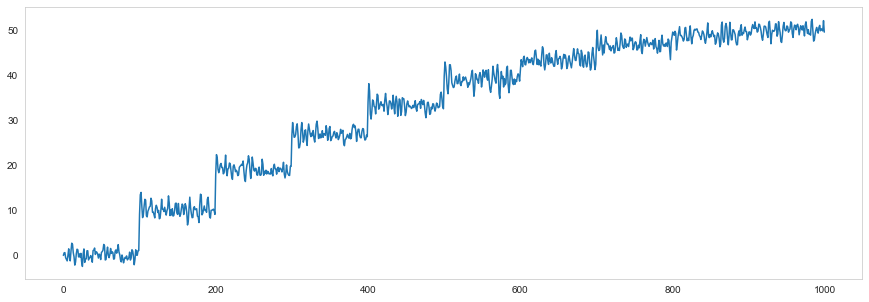

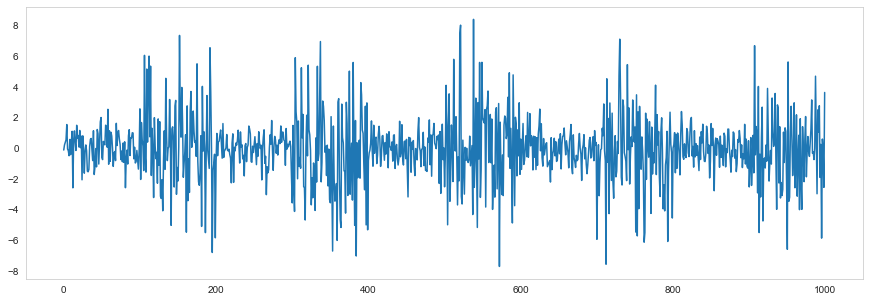

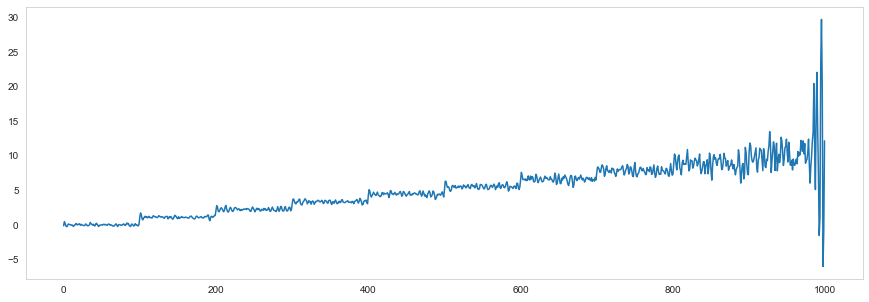

In [38]:
plt.plot(ds1)
plt.show()
plt.plot(ds2)
plt.show()
plt.plot(ds3)
plt.show()

Time-Series for Test

In [39]:
data = get_data(".NSEI", 'D')
data = data["Close"].values

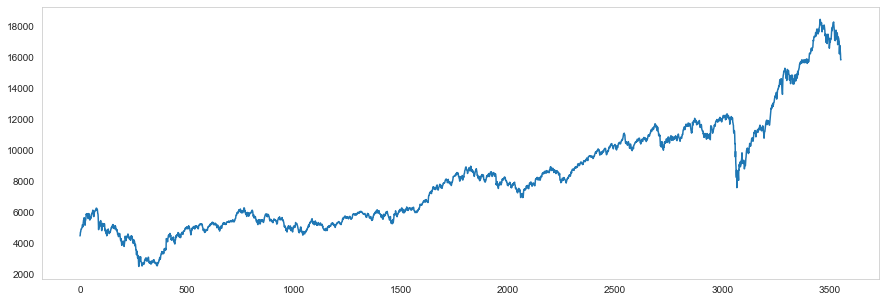

In [40]:
plt.plot(data)

In [41]:
data = {"VarMuConstSig": ds1, "ConstMuVarSig": ds2, "VarMuVarSig": ds3, ".NSEI": data}

Changefinder module

In [42]:
def plot_regimes_changefinder(data_inp):
    """
    r: Coefficient of oblivion AR model. 0 <r <1
    order: Degree of oblivion AR model
    smooth: Section length for moving average smoothing of calculated outlier scores
    """
    for key in data_inp.keys():
        data = data_inp[key]
        cf = changefinder.ChangeFinder(r=0.01, order=1, smooth=7)

        ret = []
        for i in data:
            score = cf.update(i)
            ret.append(score)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(data,'r')
        ax2 = ax.twinx()
        ax2.plot(ret)
        plt.title(key)
        plt.show()


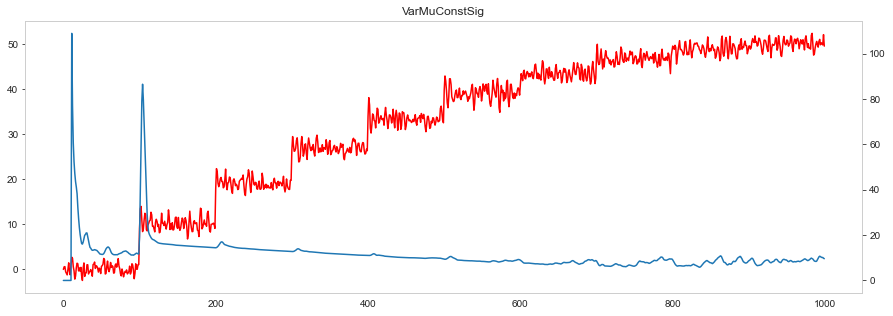

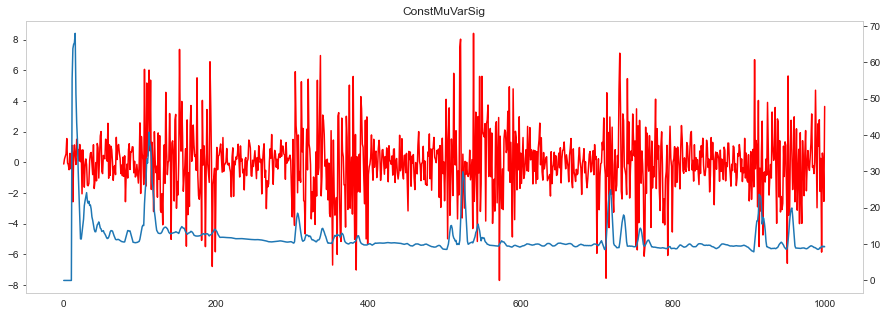

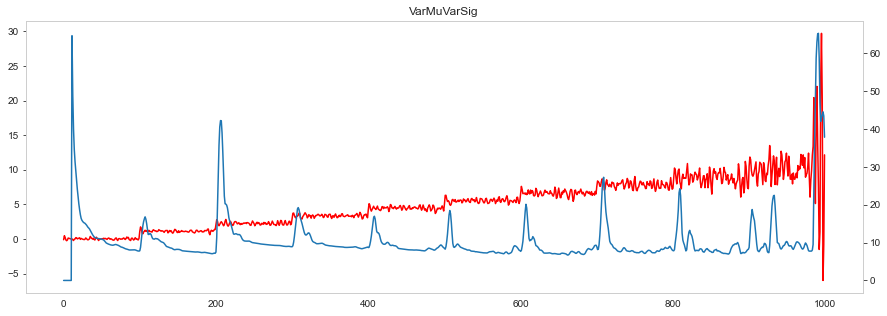

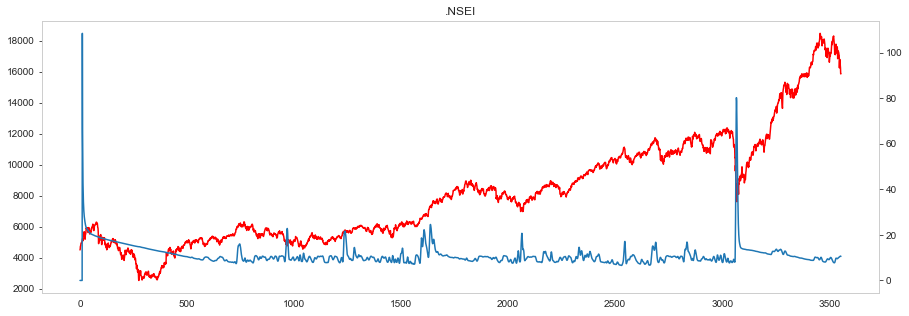

In [43]:
plot_regimes_changefinder(data)

Ruptures module

1) Pruned Exact Linear Time (PELT) search method
2) Dynamic programming search method
3) Binary segmentation search method
4) Window-based search method

In [44]:
def plot_regimes_ruptures(data_inp, dataset, method = "Pelt", plot=False):
    """
    model: segment model, ["l1", "l2", "rbf"]. Can create a custom cost too.
    min_size (int, optional): minimum segment length.
    jump (int, optional): subsample (one every *jump* points).
    """
    data = data_inp[dataset]
    method_to_call = getattr(rpt, method)
    algo = method_to_call(model="rbf", min_size=2, jump=5).fit(data)
    result = algo.predict(pen=10)

    if plot:
        # display
        rpt.display(data, result)
        plt.title(dataset)
        plt.show()
    return result


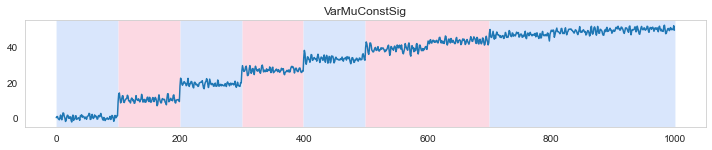

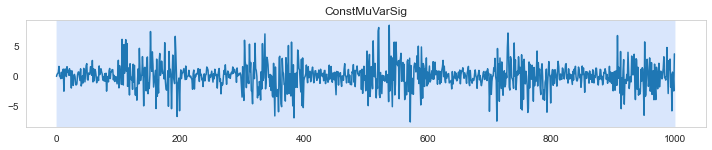

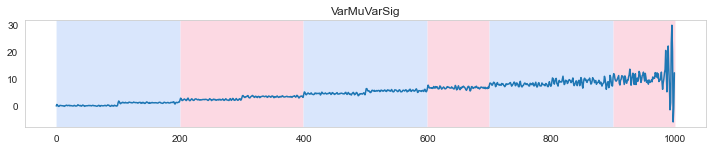

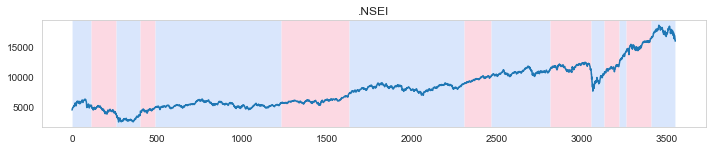

[115,
 260,
 400,
 490,
 1230,
 1630,
 2310,
 2470,
 2815,
 3060,
 3135,
 3225,
 3265,
 3410,
 3555]

In [45]:
plot_regimes_ruptures(data, "VarMuConstSig" ,method = "Pelt", plot=True)
plot_regimes_ruptures(data, "ConstMuVarSig" ,method = "Pelt", plot=True)
plot_regimes_ruptures(data, "VarMuVarSig" ,method = "Pelt", plot=True)
plot_regimes_ruptures(data, ".NSEI" ,method = "Pelt", plot=True)

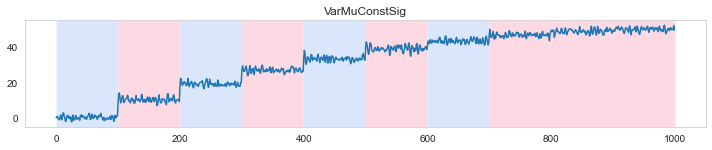

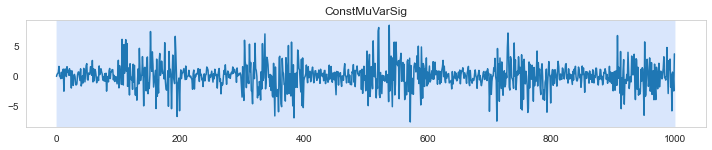

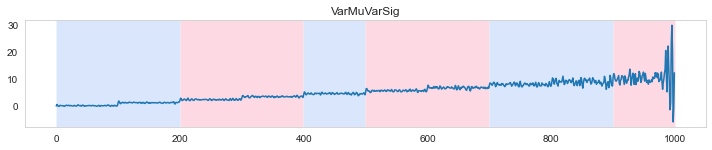

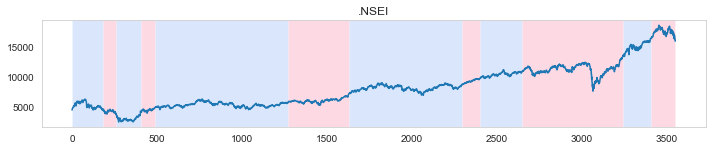

[185, 260, 405, 490, 1270, 1635, 2300, 2405, 2650, 3245, 3410, 3555]

In [46]:
plot_regimes_ruptures(data, "VarMuConstSig" ,method = "Binseg", plot=True)
plot_regimes_ruptures(data, "ConstMuVarSig" ,method = "Binseg", plot=True)
plot_regimes_ruptures(data, "VarMuVarSig" ,method = "Binseg", plot=True)
plot_regimes_ruptures(data, ".NSEI" ,method = "Binseg", plot=True)

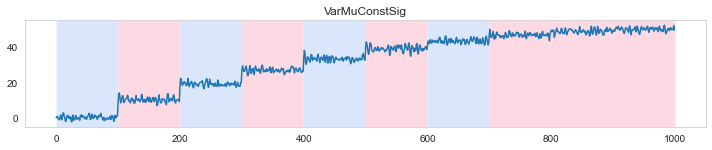

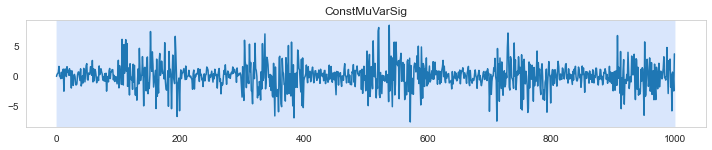

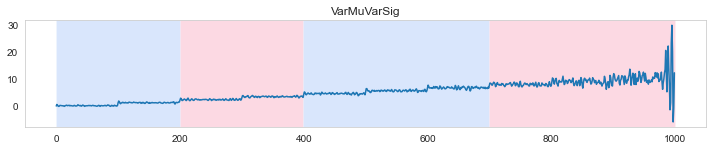

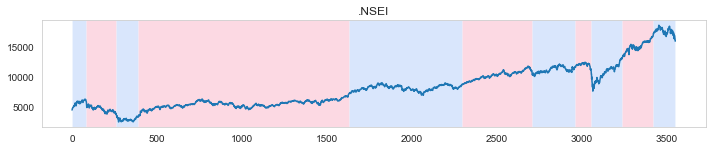

[85, 260, 390, 1630, 2295, 2710, 2965, 3060, 3240, 3425, 3555]

In [47]:
plot_regimes_ruptures(data, "VarMuConstSig" ,method = "Window", plot=True)
plot_regimes_ruptures(data, "ConstMuVarSig" ,method = "Window", plot=True)
plot_regimes_ruptures(data, "VarMuVarSig" ,method = "Window", plot=True)
plot_regimes_ruptures(data, ".NSEI" ,method = "Window", plot=True)

In [48]:
#Assumes number of breakpoints is known
def plot_regimes_ruptures_Dynp(data_inp):
    """
    model: segment model, ["l1", "l2", "rbf"]. Can create a custom cost too.
    min_size (int, optional): minimum segment length.
    jump (int, optional): subsample (one every *jump* points).
    """
    for key in data_inp.keys():
        data = data_inp[key]
        algo = rpt.Dynp(model="rbf", min_size=2, jump=5).fit(data)
        result = algo.predict(n_bkps=10)

        # display
        rpt.display(data, result)
        plt.title(key)
        plt.show()

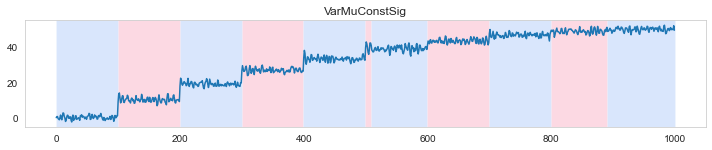

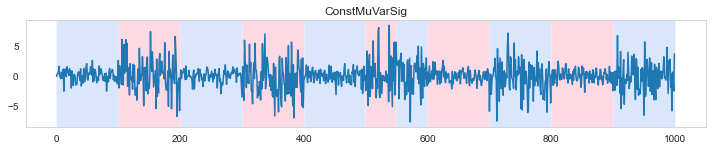

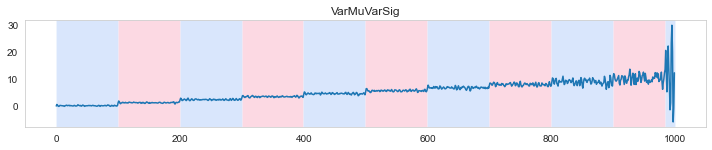

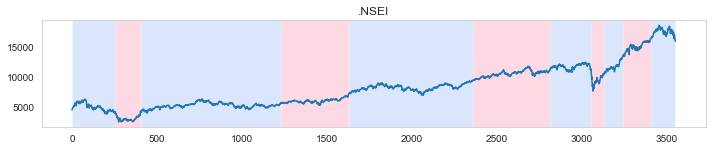

In [49]:
plot_regimes_ruptures_Dynp(data)

Bayesian Changepoint Detection :
https://github.com/hildensia/bayesian_changepoint_detection/blob/master/Example_Code.ipynb

In [50]:
def plot_regimes_Bayesian_offline(data_inp):
    """
    model: segment model, ["l1", "l2", "rbf"]. Can create a custom cost too.
    min_size (int, optional): minimum segment length.
    jump (int, optional): subsample (one every *jump* points).
    """
    for key in data_inp.keys():
        data = data_inp[key]
        data = np.reshape(data,(-1,1))
        prior_function = partial(const_prior, p=1/(len(data) + 1))
        Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-40)

        fig, ax = plt.subplots(2, figsize=[18, 16])
        ax[0].plot(data[:])
        ax[1].plot(np.exp(Pcp).sum(0))

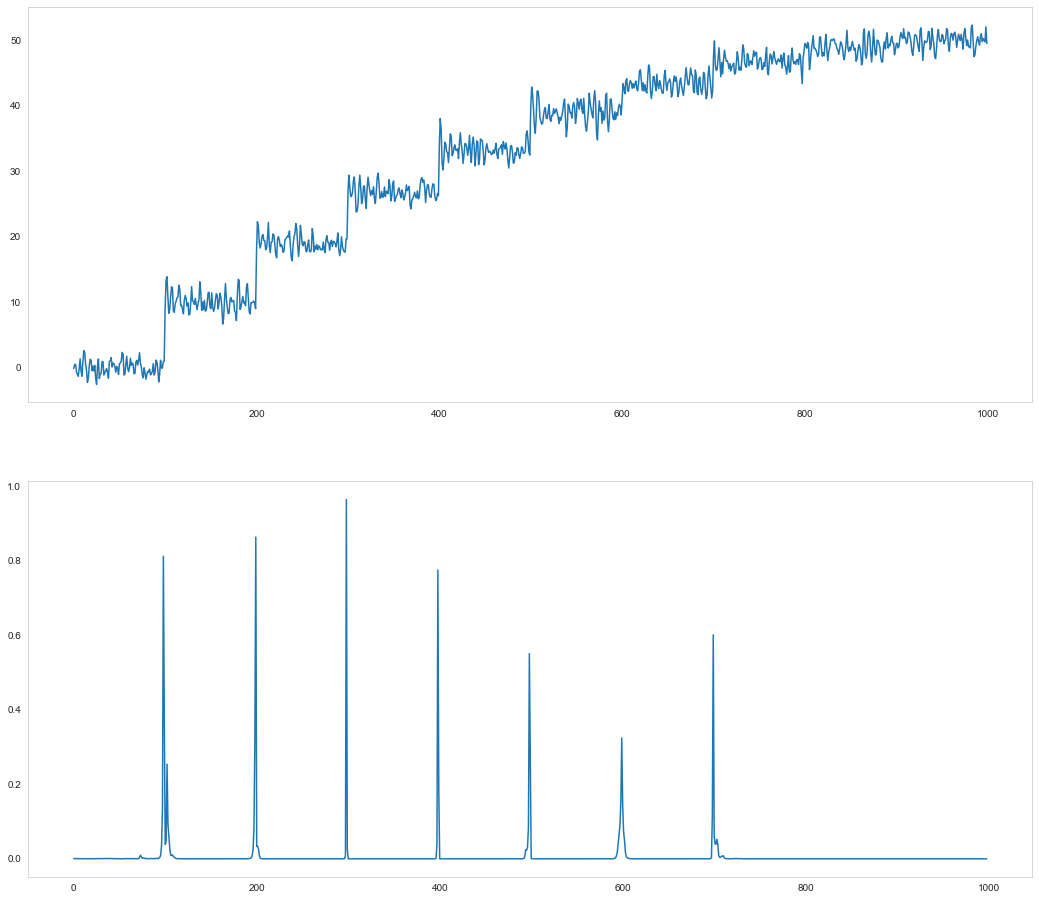

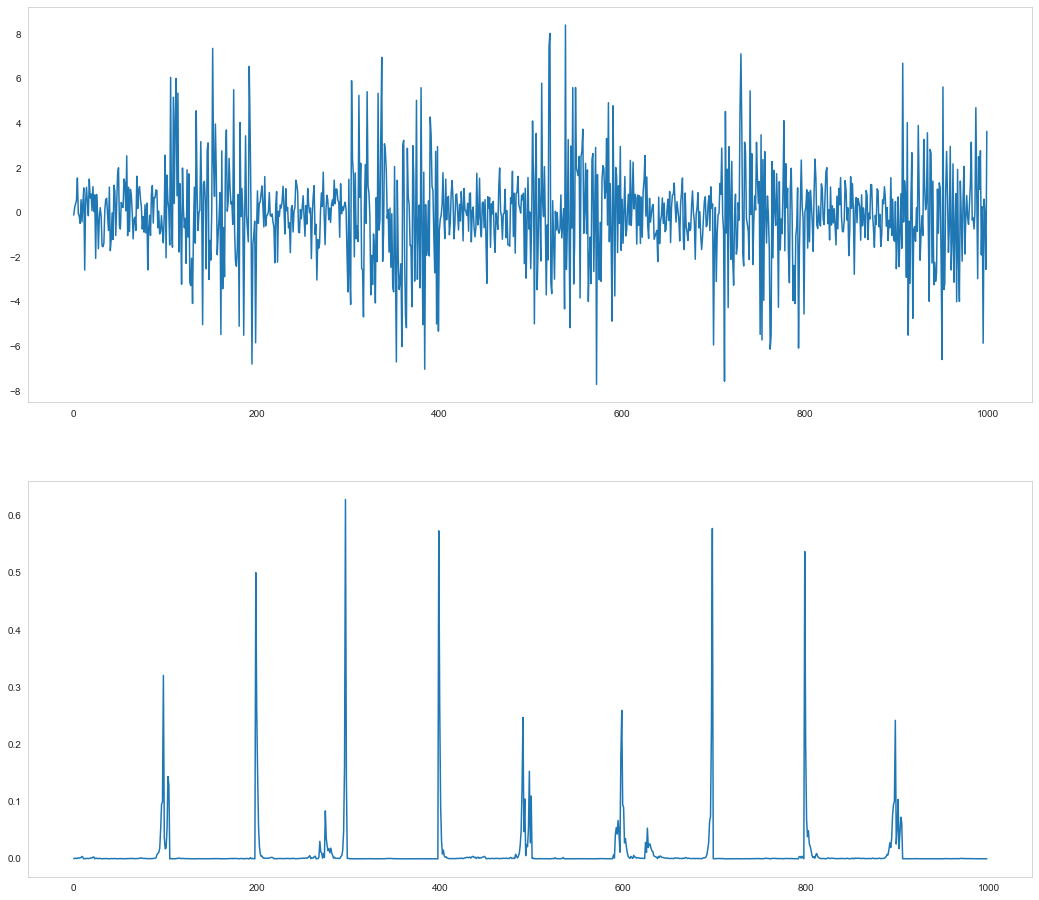

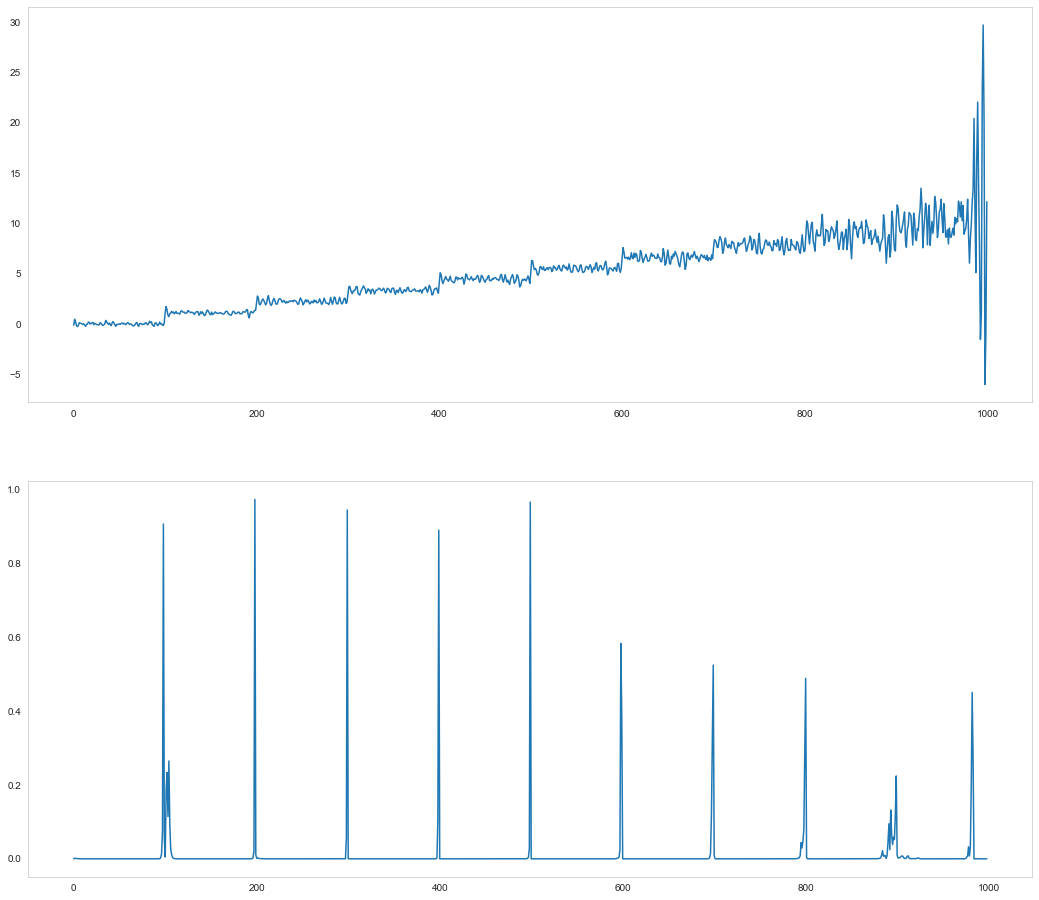

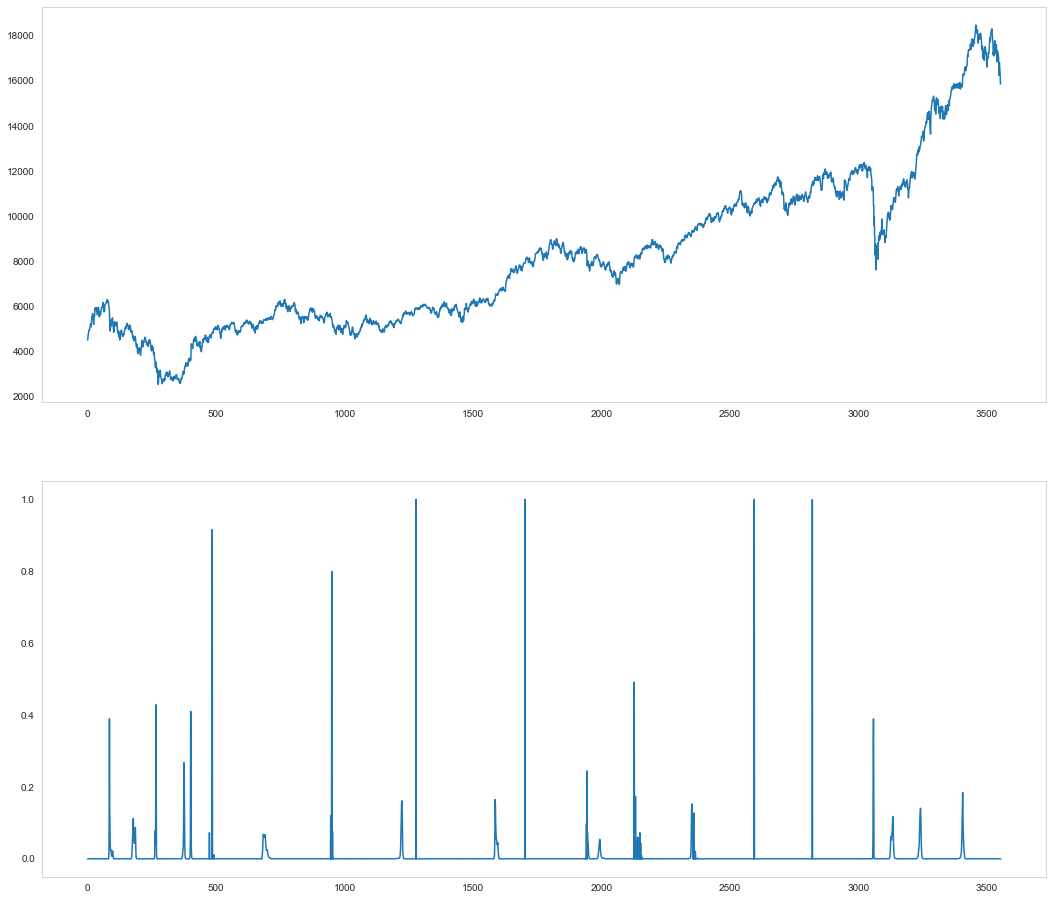

In [51]:

plot_regimes_Bayesian_offline(data)

In [52]:
def plot_regimes_Bayesian_online(data_inp):
    """
    model: segment model, ["l1", "l2", "rbf"]. Can create a custom cost too.
    min_size (int, optional): minimum segment length.
    jump (int, optional): subsample (one every *jump* points).
    """
    for key in data_inp.keys():
        data = data_inp[key]
        data = np.reshape(data,(-1,1))
        hazard_function = partial(constant_hazard, 250)
        R, maxes = online_changepoint_detection(
            data, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
        )

        epsilon = 1e-7
        fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
        ax[0].plot(data)
        sparsity = 5  # only plot every fifth data for faster display
        density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
        ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)),
                  np.array(range(0, len(R[:,0]), sparsity)),
                  density_matrix,
                  cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
                    shading='auto')
        Nw=10
        ax[2].plot(R[Nw,Nw:-1])


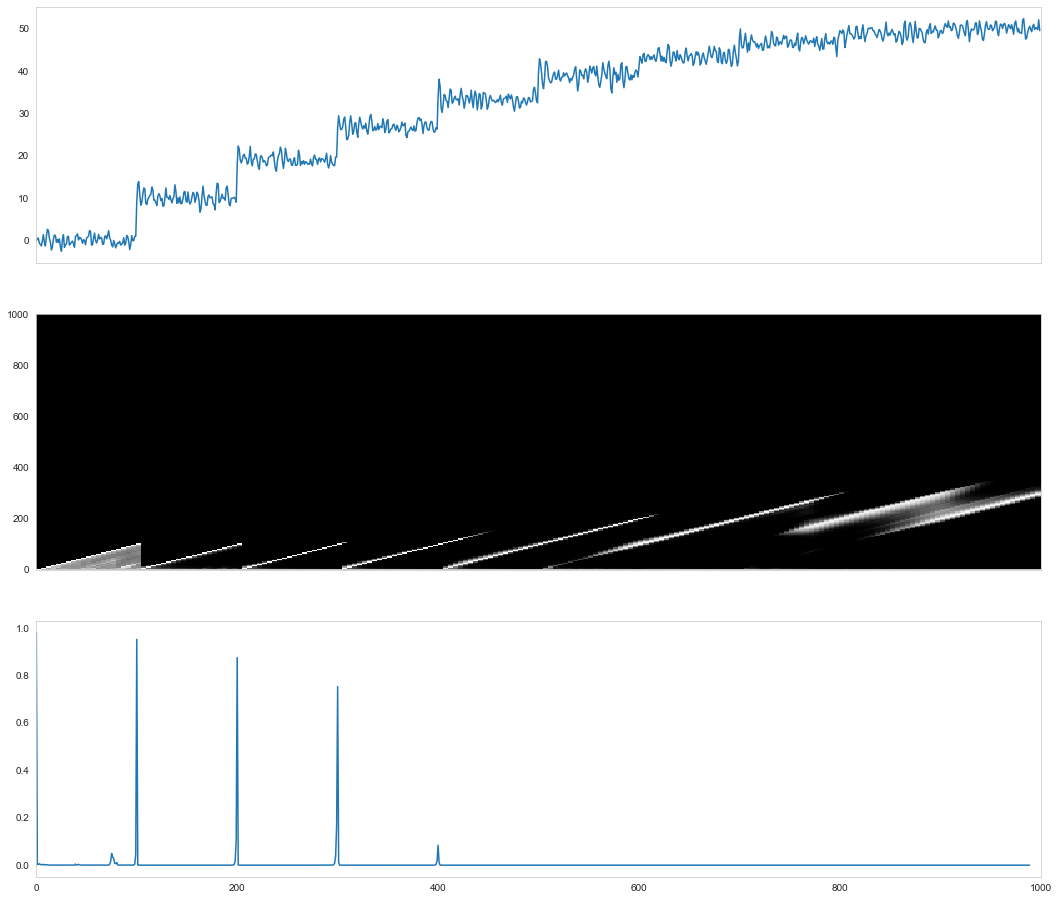

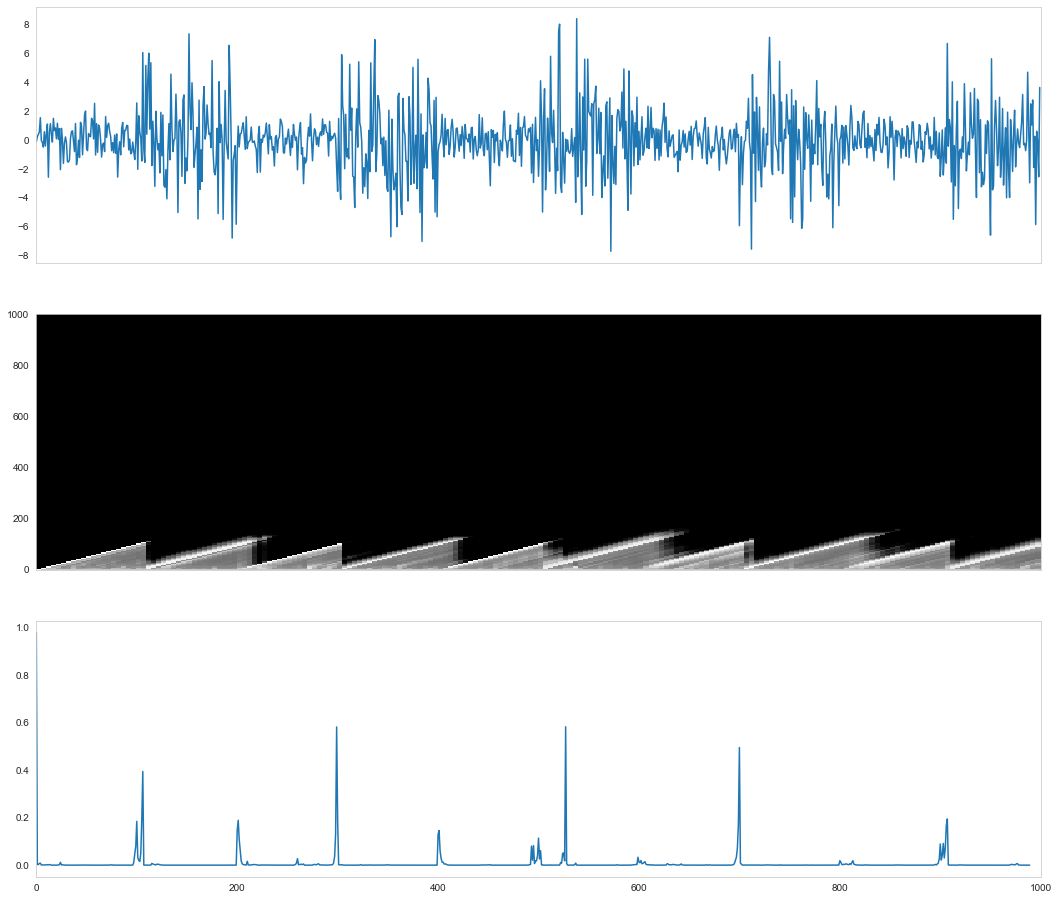

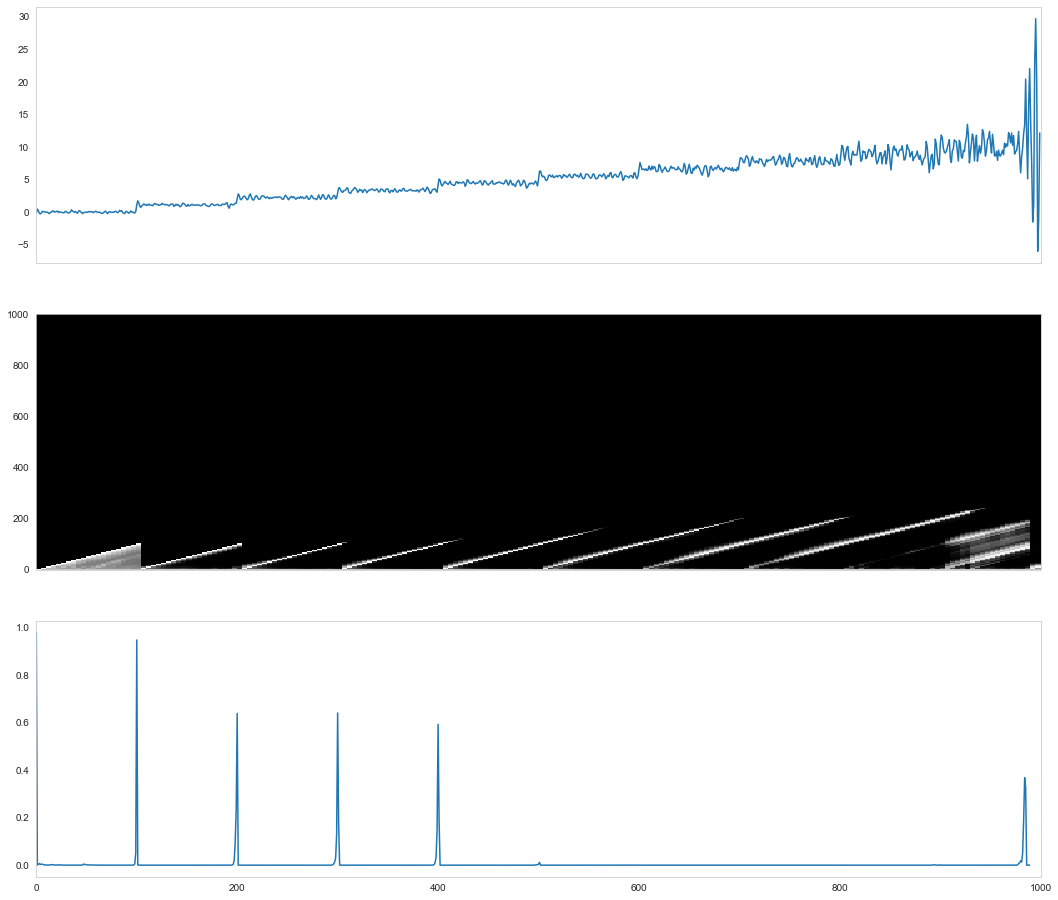

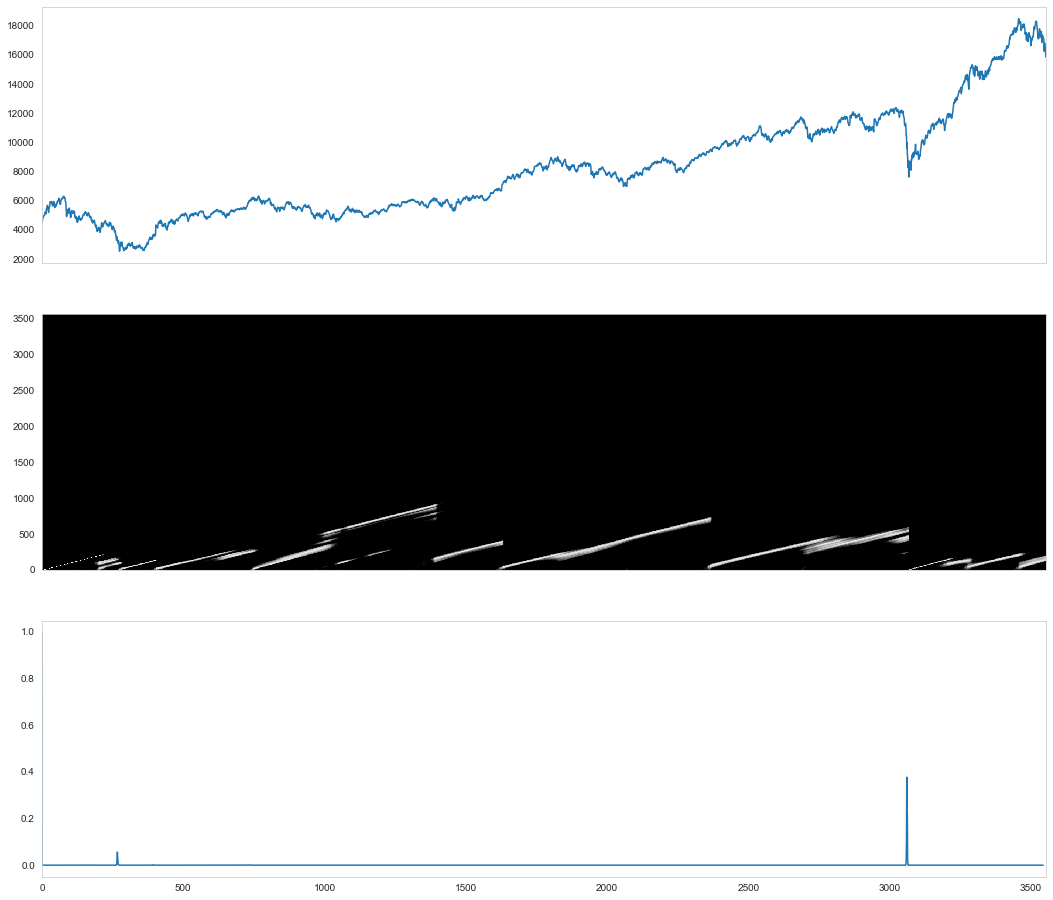

In [53]:
plot_regimes_Bayesian_online(data)


Analysing regimes based on breakpoints obtained from Ruptures

In [56]:
def get_changepoints(data, method, plot=False):
    """
    model: segment model, ["l1", "l2", "rbf"]. Can create a custom cost too.
    min_size (int, optional): minimum segment length.
    jump (int, optional): subsample (one every *jump* points).
    """
    data = data["Close"].values
    method_to_call = getattr(rpt, method)
    algo = method_to_call(model="rbf", min_size=2, jump=5).fit(data)
    result = algo.predict(pen=10)

    if plot:
        # display
        rpt.display(data, result)
        plt.title("Changepoints")
        plt.show()
    return result

In [57]:
def prepare_data(ticker, plot=True):
    df = get_data(ticker, 'D')
    results = get_changepoints(df,method = "Pelt")
    results = [result-1 for result in results]
    df["Regimes"] = 0
    df.loc[results, "Regimes"] = 1
    df["Regimes"] = df["Regimes"].expanding().sum()
    df["Returns"] = np.log(df['Close'] / df['Close'].shift(1))

    if plot:
        for regime in range(int(df.iloc[-1]["Regimes"])):
            df[df["Regimes"]==regime]["Close"].plot()
        plt.show()
        for regime in range(int(df.iloc[-1]["Regimes"])):
            df[df["Regimes"]==regime]["Returns"].plot()
        plt.show()
    data = []
    for regime in range(int(df.iloc[-1]["Regimes"])):
        data.append({
            "df": df[df["Regimes"]==regime],
            "rets": df[df["Regimes"]==regime]["Returns"].values,
            "mean": df[df["Regimes"]==regime]["Returns"].mean(),
            "stdev": df[df["Regimes"]==regime]["Returns"].std(),
            "skew": df[df["Regimes"]==regime]["Returns"].skew(),
            "kurt": df[df["Regimes"]==regime]["Returns"].kurt()

        })
    return df, data

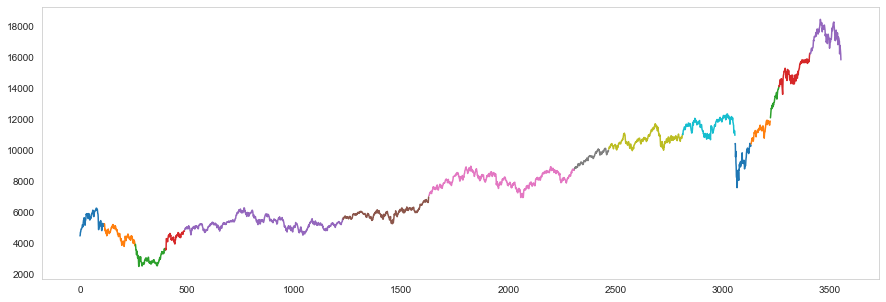

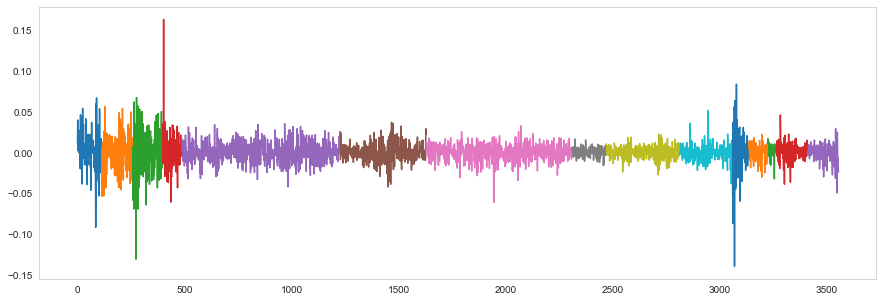

In [58]:
df, data = prepare_data(".NSEI", plot=True)


Clustering Distributions based on Central Tendencies and Visualising them


In [59]:
def plot_clusters(data, n_clusters=3, method='PCA'):
    stats = pd.DataFrame(data)[["mean", "stdev", "skew", "kurt"]].values
    scaler = StandardScaler()
    scaled_stats = pd.DataFrame(scaler.fit_transform(stats))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(scaled_stats)
    clusters = kmeans.predict(scaled_stats)
    scaled_stats["Cluster"] = clusters

    if method=="PCA":
        pca_2d = PCA(n_components=2)
        PCs_2d = pd.DataFrame(pca_2d.fit_transform(scaled_stats.drop(["Cluster"], axis=1)))
        PCs_2d.columns = ["PC1_2d", "PC2_2d"]
        scaled_stats = pd.concat([scaled_stats, PCs_2d], axis=1, join='inner')
        cluster0 = scaled_stats[scaled_stats["Cluster"] == 0]
        cluster1 = scaled_stats[scaled_stats["Cluster"] == 1]
        cluster2 = scaled_stats[scaled_stats["Cluster"] == 2]
        trace1 = go.Scatter(
                            x = cluster0["PC1_2d"],
                            y = cluster0["PC2_2d"],
                            mode = "markers",
                            name = "Cluster 0",
                            marker = dict(color = 'rgba(255, 0, 0, 0.8)'),
                            text = None)

        trace2 = go.Scatter(
                            x = cluster1["PC1_2d"],
                            y = cluster1["PC2_2d"],
                            mode = "markers",
                            name = "Cluster 1",
                            marker = dict(color = 'rgba(0, 255, 0, 0.8)'),
                            text = None)

        trace3 = go.Scatter(
                            x = cluster2["PC1_2d"],
                            y = cluster2["PC2_2d"],
                            mode = "markers",
                            name = "Cluster 2",
                            marker = dict(color = 'rgba(0, 0, 255, 0.8)'),
                            text = None)

        data = [trace1, trace2, trace3]

        title = "Visualizing Clusters in Two Dimensions Using PCA"

        layout = dict(title = title,
                      xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                      yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                     )

        fig = dict(data = data, layout = layout)

        iplot(fig)

    if method=='TSNE':
        perplexity = 10
        tsne_2d = TSNE(n_components=2, perplexity=perplexity)
        TCs_2d = pd.DataFrame(tsne_2d.fit_transform(scaled_stats.drop(["Cluster"], axis=1)))
        TCs_2d.columns = ["TC1_2d","TC2_2d"]
        scaled_stats = pd.concat([scaled_stats,TCs_2d], axis=1, join='inner')
        cluster0 = scaled_stats[scaled_stats["Cluster"] == 0]
        cluster1 = scaled_stats[scaled_stats["Cluster"] == 1]
        cluster2 = scaled_stats[scaled_stats["Cluster"] == 2]
        trace1 = go.Scatter(
                    x = cluster0["TC1_2d"],
                    y = cluster0["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

        #trace2 is for 'Cluster 1'
        trace2 = go.Scatter(
                            x = cluster1["TC1_2d"],
                            y = cluster1["TC2_2d"],
                            mode = "markers",
                            name = "Cluster 1",
                            marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                            text = None)

        #trace3 is for 'Cluster 2'
        trace3 = go.Scatter(
                            x = cluster2["TC1_2d"],
                            y = cluster2["TC2_2d"],
                            mode = "markers",
                            name = "Cluster 2",
                            marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                            text = None)

        data = [trace1, trace2, trace3]

        title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

        layout = dict(title = title,
                      xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
                      yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
                     )

        fig = dict(data = data, layout = layout)

        iplot(fig)

In [60]:
plot_clusters(data, method="PCA")

In [61]:
plot_clusters(data, method="TSNE")